In [2]:
pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
📄 INVOICE PROCESSING SYSTEM (PERSISTENT STORAGE)
✅ Loaded existing model with 1 records

📤 Please upload your invoice image(s)...


Saving batch1-0001.jpg to batch1-0001 (1).jpg

📁 Found 1 image(s) to process:
  1. batch1-0001 (1).jpg


🔄 Processing: batch1-0001 (1).jpg
Loading image...
Enhancing image quality...
Extracting text from enhanced images...
Extracting structured data...

=== EXTRACTED TEXT ===
--------------------------------------------------
Invoice no: 51109338

Date of issue:

1 Seller:

Andrews, Kirby and Valdez
58861 Gonzalez Prairie
Lake Daniellefurt, IN 57228

Tax Id: 945-82-2137
IBAN: GB75MCRLO6841367619257

—____] ITEMS

04/13/2013

Client:

Becker Ltd
8012 Stewart Summit Apt. 455
North Douglas, AZ 95355

Tax Id: 942-80-0517

 

 

 

 

 

 

 

 

1 SUMMARY

 

No. Description Qty UM Net price Net worth VAT [%) Gross
worth
1 CLEARANCE! Fast Dell Ocsktop 3,00 each 209,00 627,00 10% 689,70
Computer PC DUAL CORE
WINDOWS 10 4/8/16GB RAM
2. HP T520 Thin Client Computer 5.00 each 37,75 188,75 10% 207.63
AMD GX-212)C 1.2GHz 4GB RAM
TESTED !!READ BELOW!
3 gaming pc desktop computer 1,00 each 400.00 

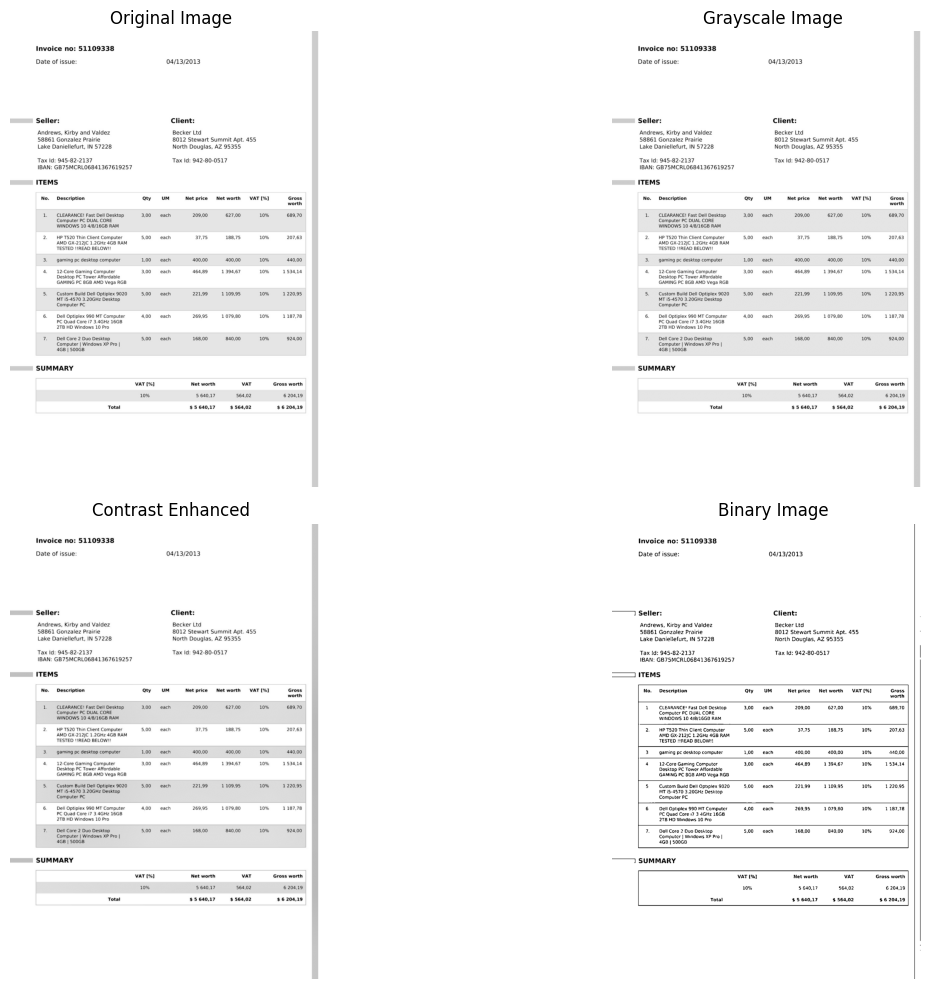


📋 EXTRACTED DATA SUMMARY
📄 Invoice No: 51109338
📅 Date of Issue: Not found
🏢 Seller: Andrews, Kirby and Valdez, 58861 Gonzalez Prairie, Lake Daniellefurt, IN 57228
👤 Client: Becker Ltd, 8012 Stewart Summit Apt. 455, North Douglas, AZ 95355
📊 VAT (%): Not found
💵 Net Worth: $5640,17
💰 VAT: $564,02
💳 Gross Worth: $6204,19
🕒 Processed: 2025-11-29 10:27:44
📂 Appending to existing file: invoices_database.xlsx
✅ Data appended to invoices_database.xlsx
📊 Total invoices in database: 2
✅ Model saved as invoice_processor_model.pkl with 2 total records

📥 Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: invoices_database.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: invoice_processor_model.pkl

✅ PROCESSING COMPLETED!
📊 Invoices processed in this session: 1
🤖 Model file: invoice_processor_model.pkl
📚 Database file: invoices_database.xlsx

💡 TIP: Keep both files. Next time you upload new invoices,
   upload these files first to append new data!


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import pytesseract
from pytesseract import Output
from skimage.filters import threshold_local
from PIL import Image
import pandas as pd
from datetime import datetime
import os
from google.colab.patches import cv2_imshow
import glob
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Install required packages
!sudo apt install tesseract-ocr
!pip install pytesseract scikit-image openpyxl pandas joblib scikit-learn

# Constants for file names
MASTER_EXCEL_FILE = "invoices_database.xlsx"
MODEL_FILE = "invoice_processor_model.pkl"

def load_and_preprocess_image(image_path):
    """Load and preprocess the image with enhanced preprocessing"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image if too large for better processing
    height, width = image.shape[:2]
    if height > 2000 or width > 2000:
        scale = min(2000/height, 2000/width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return image

def enhance_image_quality(image):
    """Enhanced image quality improvement for better OCR"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Multiple enhancement techniques
    # 1. Denoising
    denoised = cv2.medianBlur(gray, 3)

    # 2. Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(denoised)

    # 3. Adaptive thresholding
    T = threshold_local(contrast_enhanced, 15, offset=12, method="gaussian")
    binary = (contrast_enhanced > T).astype("uint8") * 255

    # 4. Morphological operations to clean up the image
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return binary, contrast_enhanced, gray

def extract_text_from_image(image):
    """Enhanced text extraction with multiple OCR configurations"""
    # Try different PSM modes for better results
    configs = [
        r'--oem 3 --psm 6',  # Uniform block of text
        r'--oem 3 --psm 4',  # Single column of text
        r'--oem 3 --psm 3',  # Fully automatic page segmentation
    ]

    best_text = ""
    best_config = ""

    for config in configs:
        try:
            text = pytesseract.image_to_string(image, config=config)
            if len(text) > len(best_text):
                best_text = text
                best_config = config
        except:
            continue

    # Get detailed data with best config
    detailed_data = pytesseract.image_to_data(image, output_type=Output.DICT, config=best_config)

    return best_text, detailed_data

def extract_invoice_number(text):
    """Extract invoice number"""
    patterns = [
        r'Invoice\s*no\s*:?\s*(\d+)',
        r'Invoice\s*#?\s*:?\s*(\d+)',
        r'Invoice\s*Number\s*:?\s*(\d+)',
        r'INV\s*:?\s*(\d+)',
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            return matches[0]

    return ""

def extract_date_of_issue(text):
    """Extract Date of issue"""
    patterns = [
        r'Date\s*of\s*issue\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
        r'Issue\s*Date\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
        r'Date\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            return matches[0]

    return ""

def extract_seller_info(text):
    """Extract seller information"""
    seller_name = ""
    seller_address = ""

    # Look for "Seller:" section
    seller_match = re.search(r'Seller\s*:?\s*\n\s*([^\n]+)', text, re.IGNORECASE)
    if seller_match:
        seller_name = seller_match.group(1).strip()

        # Try to get address lines after seller name
        lines = text.split('\n')
        seller_idx = -1
        for i, line in enumerate(lines):
            if seller_name in line:
                seller_idx = i
                break

        if seller_idx >= 0 and seller_idx + 1 < len(lines):
            address_lines = []
            for i in range(seller_idx + 1, min(seller_idx + 4, len(lines))):
                line = lines[i].strip()
                if line and not line.lower().startswith('client') and not line.lower().startswith('tax'):
                    address_lines.append(line)
                else:
                    break
            seller_address = ', '.join(address_lines)

    return f"{seller_name}, {seller_address}".strip(', ')

def extract_client_info(text):
    """Extract client information"""
    client_name = ""
    client_address = ""

    # Look for "Client:" section
    client_match = re.search(r'Client\s*:?\s*\n\s*([^\n]+)', text, re.IGNORECASE)
    if client_match:
        client_name = client_match.group(1).strip()

        # Try to get address lines after client name
        lines = text.split('\n')
        client_idx = -1
        for i, line in enumerate(lines):
            if client_name in line:
                client_idx = i
                break

        if client_idx >= 0 and client_idx + 1 < len(lines):
            address_lines = []
            for i in range(client_idx + 1, min(client_idx + 3, len(lines))):
                line = lines[i].strip()
                if line and not line.lower().startswith('tax') and not line.lower().startswith('items'):
                    address_lines.append(line)
                else:
                    break
            client_address = ', '.join(address_lines)

    return f"{client_name}, {client_address}".strip(', ')

def extract_summary_totals(text):
    """Extract VAT%, Net Worth, VAT, and Gross Worth from SUMMARY section"""
    vat_percent = ""
    net_worth = ""
    vat_amount = ""
    gross_worth = ""

    # Look for the summary table
    # Pattern for VAT percentage
    vat_percent_match = re.search(r'VAT\s*\[%\]\s*\n?\s*(\d+)%', text, re.IGNORECASE)
    if vat_percent_match:
        vat_percent = vat_percent_match.group(1) + "%"

    # Pattern for totals row
    totals_patterns = [
        r'Total\s+\$?\s*([\d\s,]+\.?\d*)\s+\$\s*([\d\s,]+\.?\d*)\s+\$\s*([\d\s,]+\.?\d*)',
        r'\d+%\s+\$?\s*([\d\s,]+\.?\d*)\s+\$?\s*([\d\s,]+\.?\d*)\s+\$?\s*([\d\s,]+\.?\d*)',
    ]

    for pattern in totals_patterns:
        match = re.search(pattern, text)
        if match:
            net_worth = "$" + match.group(1).replace(" ", "").strip()
            vat_amount = "$" + match.group(2).replace(" ", "").strip()
            gross_worth = "$" + match.group(3).replace(" ", "").strip()
            break

    return vat_percent, net_worth, vat_amount, gross_worth

class InvoiceProcessor:
    """Model class to handle invoice processing and saving"""

    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=1000)
        self.processed_data = []
        self.model_version = "1.0"
        self.is_fitted = False

    def load_existing_model(self):
        """Load existing model if available"""
        if os.path.exists(MODEL_FILE):
            try:
                with open(MODEL_FILE, 'rb') as f:
                    model_data = pickle.load(f)
                self.vectorizer = model_data['vectorizer']
                self.processed_data = model_data['processed_data']
                self.model_version = model_data['model_version']
                self.is_fitted = model_data.get('is_fitted', False)
                print(f"✅ Loaded existing model with {len(self.processed_data)} records")
                return True
            except Exception as e:
                print(f"⚠️ Could not load existing model: {str(e)}")
                return False
        return False

    def fit(self, texts):
        """Fit the vectorizer on text data"""
        if texts:
            try:
                self.vectorizer.fit(texts)
                self.is_fitted = True
            except Exception as e:
                print(f"⚠️ Error fitting vectorizer: {str(e)}")

    def add_data(self, invoice_no, raw_text, image_path):
        """Add new data to the processor"""
        self.processed_data.append({
            'invoice_no': invoice_no,
            'raw_text': raw_text,
            'image_path': image_path,
            'timestamp': datetime.now()
        })

    def save_model(self, filename=MODEL_FILE):
        """Save the trained model"""
        model_data = {
            'vectorizer': self.vectorizer,
            'processed_data': self.processed_data,
            'model_version': self.model_version,
            'is_fitted': self.is_fitted,
            'timestamp': datetime.now()
        }

        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"✅ Model saved as {filename} with {len(self.processed_data)} total records")
        return filename

def process_invoice(image_path, processor=None):
    """Main function to process invoice and extract structured data"""
    print("Loading image...")
    original_image = load_and_preprocess_image(image_path)

    print("Enhancing image quality...")
    binary_image, contrast_enhanced, gray_image = enhance_image_quality(original_image)

    print("Extracting text from enhanced images...")
    text_binary, _ = extract_text_from_image(binary_image)
    text_contrast, _ = extract_text_from_image(contrast_enhanced)
    text_gray, _ = extract_text_from_image(gray_image)

    # Use the best result
    texts = [text_binary, text_contrast, text_gray]
    final_text = max(texts, key=len)

    print("Extracting structured data...")

    # Extract all information
    invoice_no = extract_invoice_number(final_text)
    date_of_issue = extract_date_of_issue(final_text)
    seller = extract_seller_info(final_text)
    client = extract_client_info(final_text)
    vat_percent, net_worth, vat_amount, gross_worth = extract_summary_totals(final_text)

    # Store in processor if provided
    if processor:
        processor.add_data(invoice_no, final_text, image_path)

    # Display extracted text
    print("\n=== EXTRACTED TEXT ===")
    print("-" * 50)
    print(final_text)
    print("-" * 50)

    # Display images
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].imshow(original_image)
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')

    axes[0,1].imshow(gray_image, cmap='gray')
    axes[0,1].set_title('Grayscale Image')
    axes[0,1].axis('off')

    axes[1,0].imshow(contrast_enhanced, cmap='gray')
    axes[1,0].set_title('Contrast Enhanced')
    axes[1,0].axis('off')

    axes[1,1].imshow(binary_image, cmap='gray')
    axes[1,1].set_title('Binary Image')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'invoice_no': invoice_no,
        'date_of_issue': date_of_issue,
        'seller': seller,
        'client': client,
        'vat_percent': vat_percent,
        'net_worth': net_worth,
        'vat': vat_amount,
        'gross_worth': gross_worth,
        'raw_text': final_text,
        'processing_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'image_filename': os.path.basename(image_path)
    }

def append_to_master_excel(result):
    """Append new invoice data to the master Excel file"""

    # Prepare record
    record = {
        'Invoice No': result['invoice_no'],
        'Date of Issue': result['date_of_issue'],
        'Seller': result['seller'],
        'Client': result['client'],
        'VAT (%)': result['vat_percent'],
        'Net Worth': result['net_worth'],
        'VAT': result['vat'],
        'Gross Worth': result['gross_worth'],
        'Processing Date': result['processing_date'],
        'Image Filename': result['image_filename']
    }

    # Check if file exists
    if os.path.exists(MASTER_EXCEL_FILE):
        print(f"📂 Appending to existing file: {MASTER_EXCEL_FILE}")

        # Read existing data
        try:
            existing_df = pd.read_excel(MASTER_EXCEL_FILE)
        except Exception as e:
            print(f"⚠️ Error reading existing file: {str(e)}")
            existing_df = pd.DataFrame()

        # Append new data
        new_df = pd.DataFrame([record])
        updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        print(f"📄 Creating new file: {MASTER_EXCEL_FILE}")
        updated_df = pd.DataFrame([record])

    # Save to Excel
    updated_df.to_excel(MASTER_EXCEL_FILE, index=False)

    print(f"✅ Data appended to {MASTER_EXCEL_FILE}")

    # Get total count
    total_invoices = len(updated_df)
    print(f"📊 Total invoices in database: {total_invoices}")

    return MASTER_EXCEL_FILE

def display_extracted_summary(results):
    """Display a clean summary of extracted data"""
    print("\n" + "="*50)
    print("📋 EXTRACTED DATA SUMMARY")
    print("="*50)
    print(f"📄 Invoice No: {results['invoice_no'] or 'Not found'}")
    print(f"📅 Date of Issue: {results['date_of_issue'] or 'Not found'}")
    print(f"🏢 Seller: {results['seller'] or 'Not found'}")
    print(f"👤 Client: {results['client'] or 'Not found'}")
    print(f"📊 VAT (%): {results['vat_percent'] or 'Not found'}")
    print(f"💵 Net Worth: {results['net_worth'] or 'Not found'}")
    print(f"💰 VAT: {results['vat'] or 'Not found'}")
    print(f"💳 Gross Worth: {results['gross_worth'] or 'Not found'}")
    print(f"🕒 Processed: {results['processing_date']}")
    print("="*50)

# Main execution for Colab
if __name__ == "__main__":
    from google.colab import files
    import time

    print("📄 INVOICE PROCESSING SYSTEM (PERSISTENT STORAGE)")
    print("="*50)

    # Initialize the processor model
    processor = InvoiceProcessor()

    # Load existing model if available
    processor.load_existing_model()

    print("\n📤 Please upload your invoice image(s)...")
    uploaded = files.upload()

    image_files = list(uploaded.keys())
    all_results = []

    if image_files:
        print(f"\n📁 Found {len(image_files)} image(s) to process:")
        for i, image_file in enumerate(image_files, 1):
            print(f"  {i}. {image_file}")

        print("\n" + "="*50)

        for image_path in image_files:
            print(f"\n🔄 Processing: {image_path}")

            try:
                # Process the image and extract data
                results = process_invoice(image_path, processor)
                all_results.append(results)

                # Display summary
                display_extracted_summary(results)

                # Append to master Excel file
                append_to_master_excel(results)

                # Small delay between processing
                time.sleep(1)

            except Exception as e:
                print(f"❌ Error processing {image_path}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        # Fit/Update the processor model with all extracted texts
        if all_results:
            all_texts = [result['raw_text'] for result in all_results]

            # Combine with existing texts if model was loaded
            if processor.processed_data:
                existing_texts = [data['raw_text'] for data in processor.processed_data]
                all_texts = existing_texts + all_texts

            processor.fit(all_texts)

            # Save the updated model
            model_filename = processor.save_model()

            print(f"\n📥 Downloading files...")

            # Download the master Excel file
            if os.path.exists(MASTER_EXCEL_FILE):
                files.download(MASTER_EXCEL_FILE)
                print(f"✅ Downloaded: {MASTER_EXCEL_FILE}")

            # Download the model file
            if os.path.exists(MODEL_FILE):
                files.download(MODEL_FILE)
                print(f"✅ Downloaded: {MODEL_FILE}")

        print(f"\n{'='*50}")
        print(f"✅ PROCESSING COMPLETED!")
        print(f"{'='*50}")
        print(f"📊 Invoices processed in this session: {len(all_results)}")
        print(f"🤖 Model file: {MODEL_FILE}")
        print(f"📚 Database file: {MASTER_EXCEL_FILE}")
        print(f"\n💡 TIP: Keep both files. Next time you upload new invoices,")
        print(f"   upload these files first to append new data!")
        print(f"{'='*50}")

    else:
        print("❌ No files uploaded.")

# Model 2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
📄 INVOICE PROCESSING SYSTEM (PERSISTENT STORAGE)
✅ Loaded existing model with 3 records

📤 Please upload your invoice image(s)...


Saving batch1-0014.jpg to batch1-0014.jpg

📁 Found 1 image(s) to process:
  1. batch1-0014.jpg


🔄 Processing: batch1-0014.jpg
Loading image...
Enhancing image quality...
Extracting text from enhanced images...
Extracting structured data...

=== EXTRACTED TEXT ===
--------------------------------------------------
Invoice no: 77596491

Date of issue:

1 Seller:

Tran, Hurst and Rodgers
Unit 2493 Box 1389
OPO AP 75814

Tax Id: 988-83-0971
IBAN: GBO4ZWCK224 25880230961

—___] ITEMS

01/31/2021

Client:

Stephenson Inc
716 Wright Flat Apt. 385
South Carrie, GA 17790

Tax Id: 926-85-5660

 

 

 

 

 

No. Description Qty UM Net price Net worth VAT [%) Gross
worth
1 Earn Scruggs and the S-String 1,00 each 22,68 22,68 10% 24,95

Banjo: Revised and Enhanced

Edition (Paperback or
—____] SUMMARY

VAT [%] Net worth VAT Gross worth
10% 22.68 2.27 24.95
Total $ 22,68 $ 2,27 $ 24,95

 

 

 

 

--------------------------------------------------


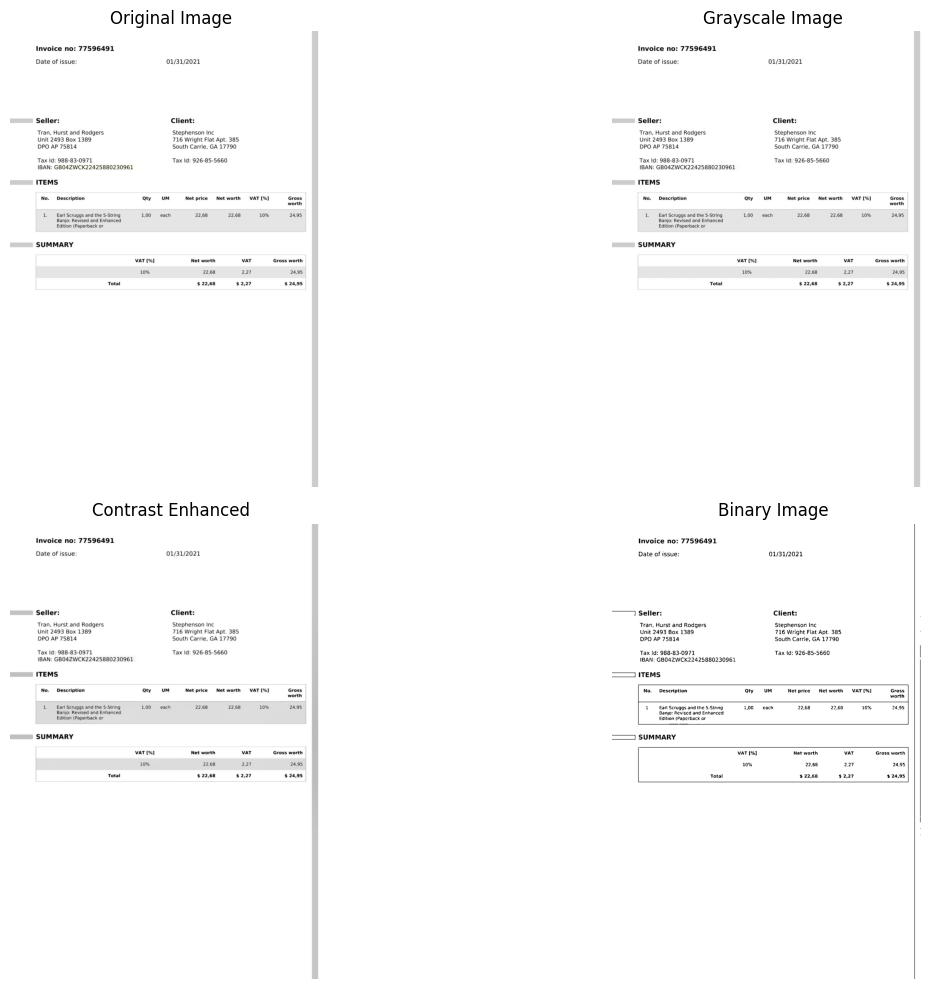


📋 EXTRACTED DATA SUMMARY
📄 Invoice No: 77596491
📅 Date of Issue: 88-83-0971
🏢 Seller: Tran, Hurst and Rodgers, Unit 2493 Box 1389, OPO AP 75814
👤 Client: Stephenson Inc, 716 Wright Flat Apt. 385, South Carrie, GA 17790
📊 VAT (%): 10%
💵 Net Worth: $22,68
💰 VAT: $2,27
💳 Gross Worth: $24,95
🕒 Processed: 2025-11-29 10:40:20
📂 Appending to existing file: invoices_database.xlsx
✅ Data appended to invoices_database.xlsx
📊 Total invoices in database: 4
✅ Model saved as invoice_processor_model.pkl with 4 total records

📥 Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: invoices_database.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: invoice_processor_model.pkl

✅ PROCESSING COMPLETED!
📊 Invoices processed in this session: 1
🤖 Model file: invoice_processor_model.pkl
📚 Database file: invoices_database.xlsx

💡 TIP: Keep both files. Next time you upload new invoices,
   upload these files first to append new data!


In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import pytesseract
from pytesseract import Output
from skimage.filters import threshold_local
from PIL import Image
import pandas as pd
from datetime import datetime
import os
from google.colab.patches import cv2_imshow
import glob
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

# Install required packages
!sudo apt install tesseract-ocr
!pip install pytesseract scikit-image openpyxl pandas joblib scikit-learn

# Constants for file names
MASTER_EXCEL_FILE = "invoices_database.xlsx"
MODEL_FILE = "invoice_processor_model.pkl"

def load_and_preprocess_image(image_path):
    """Load and preprocess the image with enhanced preprocessing"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image if too large for better processing
    height, width = image.shape[:2]
    if height > 2000 or width > 2000:
        scale = min(2000/height, 2000/width)
        new_width = int(width * scale)
        new_height = int(height * scale)
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    return image

def enhance_image_quality(image):
    """Enhanced image quality improvement for better OCR"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Multiple enhancement techniques
    # 1. Denoising
    denoised = cv2.medianBlur(gray, 3)

    # 2. Contrast enhancement using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast_enhanced = clahe.apply(denoised)

    # 3. Adaptive thresholding
    T = threshold_local(contrast_enhanced, 15, offset=12, method="gaussian")
    binary = (contrast_enhanced > T).astype("uint8") * 255

    # 4. Morphological operations to clean up the image
    kernel = np.ones((2,2), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return binary, contrast_enhanced, gray

def extract_text_from_image(image):
    """Enhanced text extraction with multiple OCR configurations"""
    # Try different PSM modes for better results
    configs = [
        r'--oem 3 --psm 6',  # Uniform block of text
        r'--oem 3 --psm 4',  # Single column of text
        r'--oem 3 --psm 3',  # Fully automatic page segmentation
    ]

    best_text = ""
    best_config = ""

    for config in configs:
        try:
            text = pytesseract.image_to_string(image, config=config)
            if len(text) > len(best_text):
                best_text = text
                best_config = config
        except:
            continue

    # Get detailed data with best config
    detailed_data = pytesseract.image_to_data(image, output_type=Output.DICT, config=best_config)

    return best_text, detailed_data

def extract_invoice_number(text):
    """Extract invoice number"""
    patterns = [
        r'Invoice\s*no\s*:?\s*(\d+)',
        r'Invoice\s*#?\s*:?\s*(\d+)',
        r'Invoice\s*Number\s*:?\s*(\d+)',
        r'INV\s*:?\s*(\d+)',
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            return matches[0]

    return ""

def extract_date_of_issue(text):
    """Extract date of issue"""
    patterns = [
        r'Date\s*of\s*issue\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
        r'Issue\s*Date\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
        r'Date\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
        r'Date\s+of\s+issue\s*:?\s*(\d{1,2}[/-]\d{1,2}[/-]\d{4})',
        r'(\d{1,2}[/-]\d{1,2}[/-]\d{4})' # General date pattern (less specific, used as fallback)
    ]

    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        if matches:
            # Prioritize dates appearing near "date" or "issue" keywords
            for match in matches:
                # Find the position of the match in the original text
                match_start = text.find(match)
                if match_start != -1:
                    # Check a window around the date for keywords
                    context_start = max(0, match_start - 50) # 50 chars before
                    context_end = min(len(text), match_start + len(match) + 50) # 50 chars after
                    context_text = text[context_start:context_end]
                    if re.search(r'(date|issue)', context_text, re.IGNORECASE):
                        return match
            # If no keyword-proximate date, return the first found date (could be any date)
            return matches[0]

    # Try looking line by line for "date of issue" keyword
    lines = text.split('\n')
    for i, line in enumerate(lines):
        if 'date of issue' in line.lower() or 'issue date' in line.lower():
            search_text = line
            if i + 1 < len(lines):
                search_text += " " + lines[i + 1] # Check next line as well
            date_match = re.search(r'(\d{1,2}[/-]\d{1,2}[/-]\d{4})', search_text)
            if date_match:
                return date_match.group(1)

    return ""

def extract_seller_info(text):
    """Extract seller information"""
    seller_name = ""
    seller_address = ""

    # Look for "Seller:" section
    seller_match = re.search(r'Seller\s*:?\s*\n\s*([^\n]+)', text, re.IGNORECASE)
    if seller_match:
        seller_name = seller_match.group(1).strip()

        # Try to get address lines after seller name
        lines = text.split('\n')
        seller_idx = -1
        for i, line in enumerate(lines):
            if seller_name in line:
                seller_idx = i
                break

        if seller_idx >= 0 and seller_idx + 1 < len(lines):
            address_lines = []
            for i in range(seller_idx + 1, min(seller_idx + 4, len(lines))):
                line = lines[i].strip()
                if line and not line.lower().startswith('client') and not line.lower().startswith('tax'):
                    address_lines.append(line)
                else:
                    break
            seller_address = ', '.join(address_lines)

    return f"{seller_name}, {seller_address}".strip(', ')

def extract_client_info(text):
    """Extract client information"""
    client_name = ""
    client_address = ""

    # Look for "Client:" section
    client_match = re.search(r'Client\s*:?\s*\n\s*([^\n]+)', text, re.IGNORECASE)
    if client_match:
        client_name = client_match.group(1).strip()

        # Try to get address lines after client name
        lines = text.split('\n')
        client_idx = -1
        for i, line in enumerate(lines):
            if client_name in line:
                client_idx = i
                break

        if client_idx >= 0 and client_idx + 1 < len(lines):
            address_lines = []
            for i in range(client_idx + 1, min(client_idx + 3, len(lines))):
                line = lines[i].strip()
                if line and not line.lower().startswith('tax') and not line.lower().startswith('items'):
                    address_lines.append(line)
                else:
                    break
            client_address = ', '.join(address_lines)

    return f"{client_name}, {client_address}".strip(', ')

def extract_summary_totals(text):
    """Extract VAT%, Net Worth, VAT, and Gross Worth from SUMMARY section"""
    vat_percent = ""
    net_worth = ""
    vat_amount = ""
    gross_worth = ""

    lines = text.split('\n')

    # Find VAT percentage - improved
    for i, line in enumerate(lines):
        if 'vat' in line.lower():
            # Look for percentage on the same line
            percent_match_line = re.search(r'(\d+)\s*%', line)
            if percent_match_line:
                vat_percent = percent_match_line.group(1) + "%"
                break
            # If not found on the same line, look in the next few lines
            for j in range(i + 1, min(i + 4, len(lines))):
                percent_match_next = re.search(r'(\d+)\s*%', lines[j])
                if percent_match_next:
                    vat_percent = percent_match_next.group(1) + "%"
                    break
            if vat_percent:
                break

    # Find the totals row(s) - more robust approach
    # First, look for a "Total" line that contains 3 monetary values
    for line in lines:
        if 'total' in line.lower():
            # Example: "Total $5 640,17 $ 564,02 $6 204,19" or "Total 5640,17 564,02 6204,19"
            # Regex to capture three monetary values that might be preceded by '$'
            match = re.search(r'total.*?(?:\$?\s*([\d\s,]+\.?\d+))\s+(?:\$?\s*([\d\s,]+\.?\d+))\s+(?:\$?\s*([\d\s,]+\.?\d+))', line, re.IGNORECASE)
            if match:
                net_worth = "$" + match.group(1).replace(" ", "").strip()
                vat_amount = "$" + match.group(2).replace(" ", "").strip()
                gross_worth = "$" + match.group(3).replace(" ", "").strip()
                break # Found all values, no need to check further lines

    # If not found in a single "Total" line, try searching for labels
    if not (net_worth and vat_amount and gross_worth):
        text_lower = text.lower()

        # Search for Net Worth
        net_match = re.search(r'(?:net\s*worth|amount\s*due)\s*[:\s]*\$?([\d\s,]+\.?\d+)', text_lower)
        if net_match:
            net_worth = "$" + net_match.group(1).replace(" ", "").strip()

        # Search for VAT Amount (excluding VAT percentage context)
        vat_amount_match = re.search(r'\bvat\b(?!\s*[%])\s*[:\s]*\$?([\d\s,]+\.?\d+)', text_lower)
        if vat_amount_match:
            vat_amount = "$" + vat_amount_match.group(1).replace(" ", "").strip()

        # Search for Gross Worth or Total Amount
        gross_match = re.search(r'(?:gross\s*worth|total\s*amount)\s*[:\s]*\$?([\d\s,]+\.?\d+)', text_lower)
        if gross_match:
            gross_worth = "$" + gross_match.group(1).replace(" ", "").strip()

    return vat_percent, net_worth, vat_amount, gross_worth

class InvoiceProcessor:
    """Model class to handle invoice processing and saving"""

    def __init__(self):
        self.vectorizer = TfidfVectorizer(max_features=1000)
        self.processed_data = []
        self.model_version = "1.0"
        self.is_fitted = False

    def load_existing_model(self):
        """Load existing model if available"""
        if os.path.exists(MODEL_FILE):
            try:
                with open(MODEL_FILE, 'rb') as f:
                    model_data = pickle.load(f)
                self.vectorizer = model_data['vectorizer']
                self.processed_data = model_data['processed_data']
                self.model_version = model_data['model_version']
                self.is_fitted = model_data.get('is_fitted', False)
                print(f"✅ Loaded existing model with {len(self.processed_data)} records")
                return True
            except Exception as e:
                print(f"⚠️ Could not load existing model: {str(e)}")
                return False
        return False

    def fit(self, texts):
        """Fit the vectorizer on text data"""
        if texts:
            try:
                self.vectorizer.fit(texts)
                self.is_fitted = True
            except Exception as e:
                print(f"⚠️ Error fitting vectorizer: {str(e)}")

    def add_data(self, invoice_no, raw_text, image_path):
        """Add new data to the processor"""
        self.processed_data.append({
            'invoice_no': invoice_no,
            'raw_text': raw_text,
            'image_path': image_path,
            'timestamp': datetime.now()
        })

    def save_model(self, filename=MODEL_FILE):
        """Save the trained model"""
        model_data = {
            'vectorizer': self.vectorizer,
            'processed_data': self.processed_data,
            'model_version': self.model_version,
            'is_fitted': self.is_fitted,
            'timestamp': datetime.now()
        }

        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)

        print(f"✅ Model saved as {filename} with {len(self.processed_data)} total records")
        return filename

def process_invoice(image_path, processor=None):
    """Main function to process invoice and extract structured data"""
    print("Loading image...")
    original_image = load_and_preprocess_image(image_path)

    print("Enhancing image quality...")
    binary_image, contrast_enhanced, gray_image = enhance_image_quality(original_image)

    print("Extracting text from enhanced images...")
    text_binary, _ = extract_text_from_image(binary_image)
    text_contrast, _ = extract_text_from_image(contrast_enhanced)
    text_gray, _ = extract_text_from_image(gray_image)

    # Use the best result
    texts = [text_binary, text_contrast, text_gray]
    final_text = max(texts, key=len)

    print("Extracting structured data...")

    # Extract all information
    invoice_no = extract_invoice_number(final_text)
    date_of_issue = extract_date_of_issue(final_text)
    seller = extract_seller_info(final_text)
    client = extract_client_info(final_text)
    vat_percent, net_worth, vat_amount, gross_worth = extract_summary_totals(final_text)

    # Store in processor if provided
    if processor:
        processor.add_data(invoice_no, final_text, image_path)

    # Display extracted text
    print("\n=== EXTRACTED TEXT ===")
    print("-" * 50)
    print(final_text)
    print("-" * 50)

    # Display images
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].imshow(original_image)
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')

    axes[0,1].imshow(gray_image, cmap='gray')
    axes[0,1].set_title('Grayscale Image')
    axes[0,1].axis('off')

    axes[1,0].imshow(contrast_enhanced, cmap='gray')
    axes[1,0].set_title('Contrast Enhanced')
    axes[1,0].axis('off')

    axes[1,1].imshow(binary_image, cmap='gray')
    axes[1,1].set_title('Binary Image')
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'invoice_no': invoice_no,
        'date_of_issue': date_of_issue,
        'seller': seller,
        'client': client,
        'vat_percent': vat_percent,
        'net_worth': net_worth,
        'vat': vat_amount,
        'gross_worth': gross_worth,
        'raw_text': final_text,
        'processing_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'image_filename': os.path.basename(image_path)
    }

def append_to_master_excel(result):
    """Append new invoice data to the master Excel file"""

    # Prepare record
    record = {
        'Invoice No': result['invoice_no'],
        'Date of Issue': result['date_of_issue'],
        'Seller': result['seller'],
        'Client': result['client'],
        'VAT (%)': result['vat_percent'],
        'Net Worth': result['net_worth'],
        'VAT': result['vat'],
        'Gross Worth': result['gross_worth'],
        'Processing Date': result['processing_date'],
        'Image Filename': result['image_filename']
    }

    # Check if file exists
    if os.path.exists(MASTER_EXCEL_FILE):
        print(f"📂 Appending to existing file: {MASTER_EXCEL_FILE}")

        # Read existing data
        try:
            existing_df = pd.read_excel(MASTER_EXCEL_FILE)
        except Exception as e:
            print(f"⚠️ Error reading existing file: {str(e)}")
            existing_df = pd.DataFrame()

        # Append new data
        new_df = pd.DataFrame([record])
        updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    else:
        print(f"📄 Creating new file: {MASTER_EXCEL_FILE}")
        updated_df = pd.DataFrame([record])

    # Save to Excel
    updated_df.to_excel(MASTER_EXCEL_FILE, index=False)

    print(f"✅ Data appended to {MASTER_EXCEL_FILE}")

    # Get total count
    total_invoices = len(updated_df)
    print(f"📊 Total invoices in database: {total_invoices}")

    return MASTER_EXCEL_FILE

def display_extracted_summary(results):
    """Display a clean summary of extracted data"""
    print("\n" + "="*50)
    print("📋 EXTRACTED DATA SUMMARY")
    print("="*50)
    print(f"📄 Invoice No: {results['invoice_no'] or 'Not found'}")
    print(f"📅 Date of Issue: {results['date_of_issue'] or 'Not found'}")
    print(f"🏢 Seller: {results['seller'] or 'Not found'}")
    print(f"👤 Client: {results['client'] or 'Not found'}")
    print(f"📊 VAT (%): {results['vat_percent'] or 'Not found'}")
    print(f"💵 Net Worth: {results['net_worth'] or 'Not found'}")
    print(f"💰 VAT: {results['vat'] or 'Not found'}")
    print(f"💳 Gross Worth: {results['gross_worth'] or 'Not found'}")
    print(f"🕒 Processed: {results['processing_date']}")
    print("="*50)

# Main execution for Colab
if __name__ == "__main__":
    from google.colab import files
    import time

    print("📄 INVOICE PROCESSING SYSTEM (PERSISTENT STORAGE)")
    print("="*50)

    # Initialize the processor model
    processor = InvoiceProcessor()

    # Load existing model if available
    processor.load_existing_model()

    print("\n📤 Please upload your invoice image(s)...")
    uploaded = files.upload()

    image_files = list(uploaded.keys())
    all_results = []

    if image_files:
        print(f"\n📁 Found {len(image_files)} image(s) to process:")
        for i, image_file in enumerate(image_files, 1):
            print(f"  {i}. {image_file}")

        print("\n" + "="*50)

        for image_path in image_files:
            print(f"\n🔄 Processing: {image_path}")

            try:
                # Process the image and extract data
                results = process_invoice(image_path, processor)
                all_results.append(results)

                # Display summary
                display_extracted_summary(results)

                # Append to master Excel file
                append_to_master_excel(results)

                # Small delay between processing
                time.sleep(1)

            except Exception as e:
                print(f"❌ Error processing {image_path}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

        # Fit/Update the processor model with all extracted texts
        if all_results:
            all_texts = [result['raw_text'] for result in all_results]

            # Combine with existing texts if model was loaded
            if processor.processed_data:
                existing_texts = [data['raw_text'] for data in processor.processed_data]
                all_texts = existing_texts + all_texts

            processor.fit(all_texts)

            # Save the updated model
            model_filename = processor.save_model()

            print(f"\n📥 Downloading files...")

            # Download the master Excel file
            if os.path.exists(MASTER_EXCEL_FILE):
                files.download(MASTER_EXCEL_FILE)
                print(f"✅ Downloaded: {MASTER_EXCEL_FILE}")

            # Download the model file
            if os.path.exists(MODEL_FILE):
                files.download(MODEL_FILE)
                print(f"✅ Downloaded: {MODEL_FILE}")

        print(f"\n{'='*50}")
        print(f"✅ PROCESSING COMPLETED!")
        print(f"{'='*50}")
        print(f"📊 Invoices processed in this session: {len(all_results)}")
        print(f"🤖 Model file: {MODEL_FILE}")
        print(f"📚 Database file: {MASTER_EXCEL_FILE}")
        print(f"\n💡 TIP: Keep both files. Next time you upload new invoices,")
        print(f"   upload these files first to append new data!")
        print(f"{'='*50}")

    else:
        print("❌ No files uploaded.")